*Created: 09/04/24*

*Most recent update: 09/04/24*

**Authors:** Ismael Mendoza

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [7]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [8]:
import galsim 
import jax_galsim as xgalsim

2024-09-06 10:05:07.194139: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-09-06 10:05:21.816291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date
import numpy as np

import matplotlib.pyplot as plt 

In [10]:
from tqdm import tqdm

In [11]:
from functools import partial

In [12]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [13]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [14]:
from bpd.chains import inference_loop

In [15]:
jax.devices()

[CudaDevice(id=0)]

In [16]:
GPU = jax.devices('gpu')[0]

In [17]:
jax.config.update("jax_default_device", GPU)

In [18]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

In [19]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # https://gist.github.com/thriveth/8560036

# Drawing methods

In [15]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [16]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

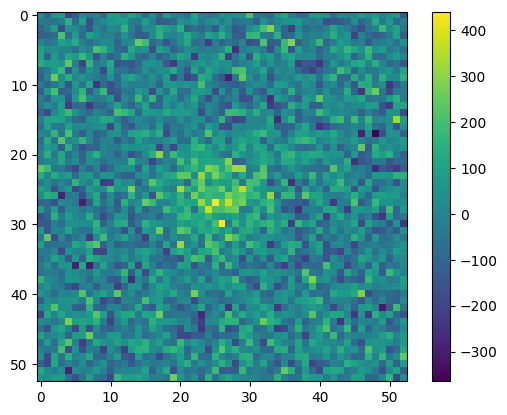

In [17]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [18]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [19]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

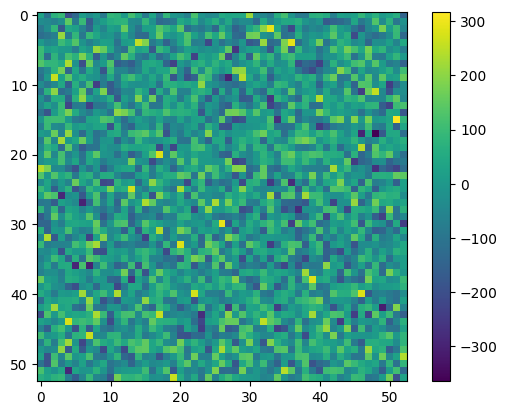

In [20]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

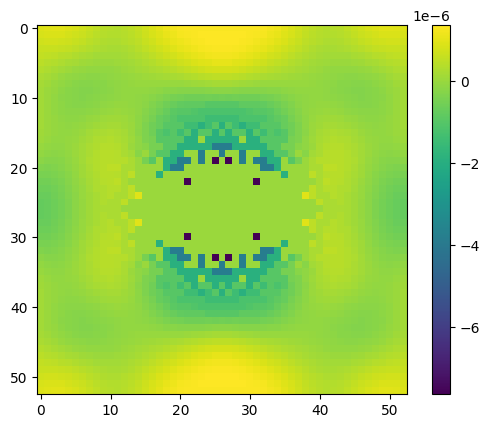

In [21]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [22]:
# timing makes sense
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)

draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

97.5 μs ± 622 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
403 μs ± 1.48 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [23]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [24]:
def prior_sample(rng_key, n:int):
    f = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['f'][0], maxval=BOUNDS_GPU['f'][1])
    hlr = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['hlr'][0], maxval=BOUNDS_GPU['hlr'][1])
    g1 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g1'][0], maxval=BOUNDS_GPU['g1'][1])
    g2 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g2'][0], maxval=BOUNDS_GPU['g2'][1])
    x = random.normal(rng_key, (n,)) * BOUNDS_GPU['x'] # mean = 0 , sigma=1
    y = random.normal(rng_key, (n,)) * BOUNDS_GPU['y'] # mean = 0, sigma=1
    
    return {'f': f, 'hlr': hlr, 'g1': g1, 'g2': g2, 'x': x, 'y': y} 

In [25]:
# sample from ball around some dictionary of true params
def sample_ball(rng_key, center_params:dict):
    new = {} 
    keys = random.split(rng_key, len(center_params.keys()))
    rng_key_dict = {p:k for p,k in zip(center_params, keys)}
    for p in center_params:
        centr = center_params[p]
        if p == 'f':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.25, maxval=centr + 0.25)
        elif p == 'hlr':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.2, maxval=centr + 0.2)
        elif p in {'g1', 'g2'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.025, maxval=centr + 0.025)
        elif p in {'x', 'y'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.5, maxval=centr + 0.5)
    return new
        


In [26]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


# Benchmark 2.2

Similar to benchmark 2 but slightly more interpretable conclusion with the question we are intereted in "Given some time T, how many effective samples do we expect to get?" 

We investigate this targeting a single noise realization with variable chains but fixed warmup steps = 500 (every chain runs its own warmup). Max doublings are also fixed = 5. 

Every chain runs the same number of samples = 1000, avg time per sample is computed to make important plot.

In [51]:
# what parameter space do we want to explore?
N_WARMUPS = 500
MAX_DOUBLINGS = 5 # maybe good enough, 10 is a lot and probably need to explore what is good in terms of warmpu first, otherwise one chain can easily get stuck
N_CHAINS = (1, 3, 5, 10, 20, 25, 40, 50, 70, 80, 85, 90, 100, 110, 120, 130, 140, 150) # probably explodes beyond 100

In [52]:
N_SAMPLES = 1000

## Run

In [53]:
SEED = 44

In [54]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1) 
data_gpu = jax.device_put(data, device=GPU)[0]
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)


In [55]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)}


In [56]:
# we create all the random keys we will need
ball_key, sample_key, warmup_key = random.split(rng_key, 3)

ball_keys = random.split(ball_key, max(N_CHAINS))
warmup_keys = random.split(warmup_key, max(N_CHAINS))
sample_keys = random.split(sample_key, max(N_CHAINS))

In [57]:
results = [] # to save all results for each chain, append new dictionary

In [58]:
all_init_positions = jax.vmap(sample_ball, in_axes=(0, None))(ball_keys, TRUE_PARAMS_GPU) # since we run 4 chains per noise realization in this case per object
all_init_positions['f'].shape

(150,)

In [59]:
# vmap only rng_key
def do_warmup(rng_key, init_position:dict, data):
    
    _logdensity = partial(_logprob_fn, data=data)
    
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, 
        is_mass_matrix_diagonal=False, 
        max_num_doublings=MAX_DOUBLINGS, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.90 # default
    )    
    return warmup.run(rng_key, init_position, N_WARMUPS) # (init_states, tuned_params), adapt_info

    
def do_inference(rng_key, init_state, data, step_size:float, inverse_mass_matrix):
    _logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(_logdensity, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, 
                           max_num_doublings=MAX_DOUBLINGS).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=N_SAMPLES) # state, info
    


In [61]:

# can be resued as we fixed warmup and samples and doublings
_run_warmup =  jax.vmap(
                        jax.jit(
                                do_warmup
                        ), in_axes=(0, 0, None)

)
_run_inference = jax.vmap(
                        jax.jit(
                                do_inference
                        ), in_axes=(0, 0, None, 0, 0)
)


print('n_chains:')
for ii, n_chains in enumerate(N_CHAINS):
    d = {} # save results in this dictionary
    print(n_chains)

        
    # subset what we need for the n_chains
    _wkeys = warmup_keys[:n_chains]
    _skeys = sample_keys[:n_chains]
    _init_positions = {p:q[:n_chains] for p,q in all_init_positions.items()}


    if ii == 0:
        # compilation times
        t1 = time.time()
        (_init_states, _tuned_params), _ = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, data_gpu))            
        t2 = time.time()
        d['warmup_comp_time'] = t2 - t1 

        t1 = time.time()
        _ = jax.block_until_ready(_run_inference(_skeys, _init_states, data_gpu, 
                                                            _tuned_params['step_size'], 
                                                            _tuned_params['inverse_mass_matrix']))
        t2 = time.time()
        d['inference_comp_time'] = t2 - t1 

    # run times
    t1 = time.time()
    (init_states, tuned_params), adapt_info = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, data_gpu))
    t2 = time.time()
    d['warmup_run_time'] = t2 - t1 

    t1 = time.time()
    states, infos = jax.block_until_ready(_run_inference(_skeys, init_states, data_gpu, 
                                                         tuned_params['step_size'], 
                                                         tuned_params['inverse_mass_matrix']
                                                        ))
    t2 = time.time()
    d['inference_run_time'] = t2 - t1 

    # save states and info for future reference
    d['states'] = states
    d['info'] = infos
    d['adapt_info'] = adapt_info
    
    results.append(d)
print('DONE!')

n_chains:
1
3
5
10
20
25
40
50
70
80
85
90
100
110
120
130
140
150
DONE!


In [62]:
results[-1]['states'].position['f'].shape

(150, 1000)

In [63]:
results_dict = {n_chains:results[ii] for ii, n_chains in enumerate(N_CHAINS)}

## Save run

In [64]:
jnp.save(f'results_benchmark-v2_2_{SEED}.npy', results_dict)

## Diagnostic plots

In [20]:
seed = 44
d = jnp.load(f'results_benchmark-v2_2_{seed}.npy', allow_pickle=True)[()]

In [21]:
N_CHAINS = np.array(list(d.keys()))
N_CHAINS

array([  1,   3,   5,  10,  20,  25,  40,  50,  70,  80,  85,  90, 100,
       110, 120, 130, 140, 150])

In [22]:
d[10]['states'].position['g1'].shape # check

(10, 1000)

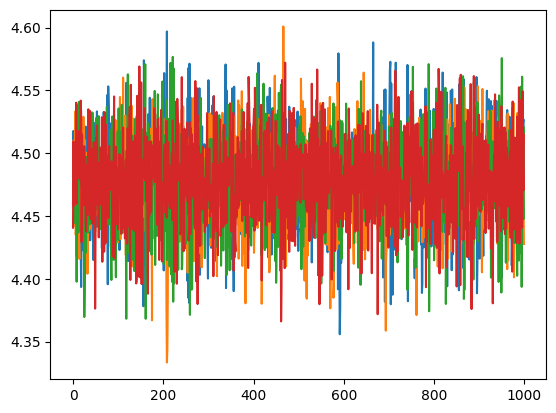

In [23]:
# example chains
plt.plot(d[10]['states'].position['f'][0, :])
plt.plot(d[10]['states'].position['f'][5, :])
plt.plot(d[10]['states'].position['f'][7, :])
plt.plot(d[10]['states'].position['f'][3, :])

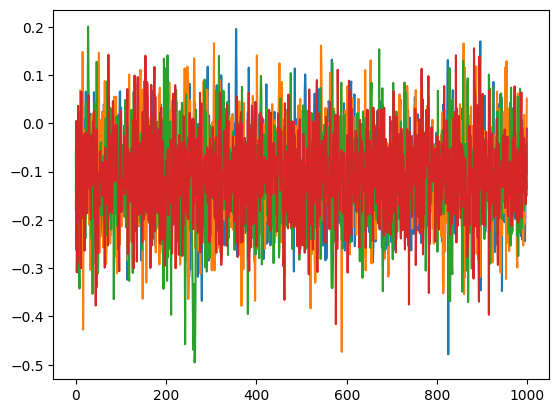

In [24]:
# example chains
plt.plot(d[10]['states'].position['g1'][0, :])
plt.plot(d[10]['states'].position['g1'][5, :])
plt.plot(d[10]['states'].position['g1'][7, :])
plt.plot(d[10]['states'].position['g1'][3, :])

In [25]:
# error on the mean
ordr = 0.01 # e.g. g1 = 0.05, this order is for shear not ellipticty more like 0.1
err_mean = jnp.std(d[100]['states'].position['g1']) / np.sqrt(10000) # but we clearly don't need it to be this small
print(err_mean, ordr / err_mean)

0.0009563465404603232 10.456460683369702


Text(0.5, 0, 'n_chains')

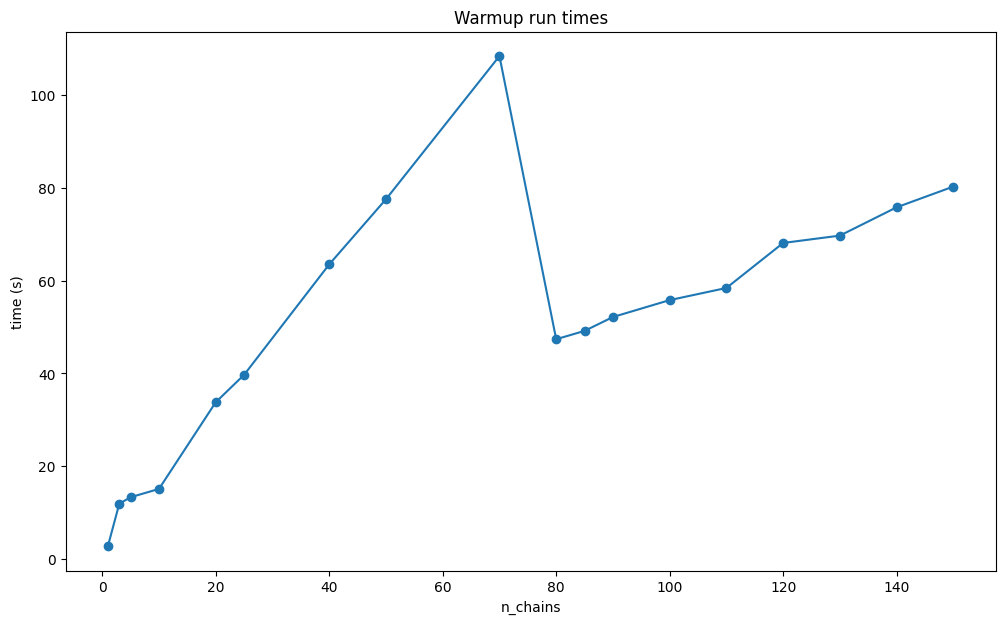

In [26]:

plt.figure(figsize=(12,7))

plt.title("Warmup run times")

rt = [ d[n]['warmup_run_time'] for n in N_CHAINS]

plt.plot(N_CHAINS, rt, '-o', color='C0')


plt.ylabel("time (s)")
plt.xlabel("n_chains")


In [27]:
d[100]['inference_run_time']

41.41324162483215

In [28]:
d[100]['inference_run_time']

41.41324162483215

Text(0.5, 0, 'n_chains')

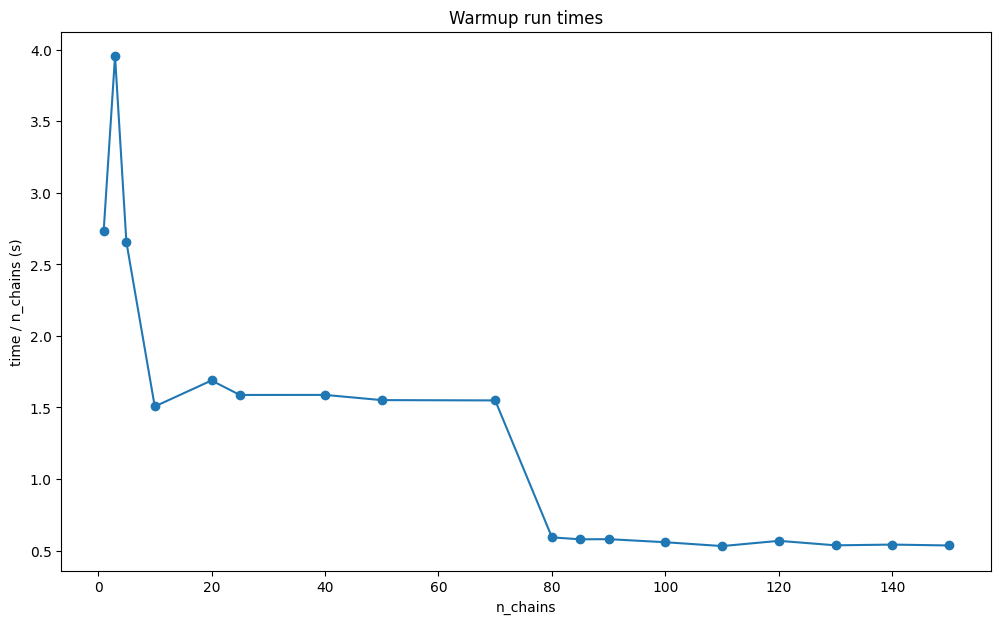

In [24]:

plt.figure(figsize=(12,7))

plt.title("Warmup run times")

rt = [ d[n]['warmup_run_time'] / n for n in N_CHAINS]

plt.plot(N_CHAINS, rt, '-o', color='C0')


plt.ylabel("time / n_chains (s)")
plt.xlabel("n_chains")


Text(0.5, 0, 'n_chains')

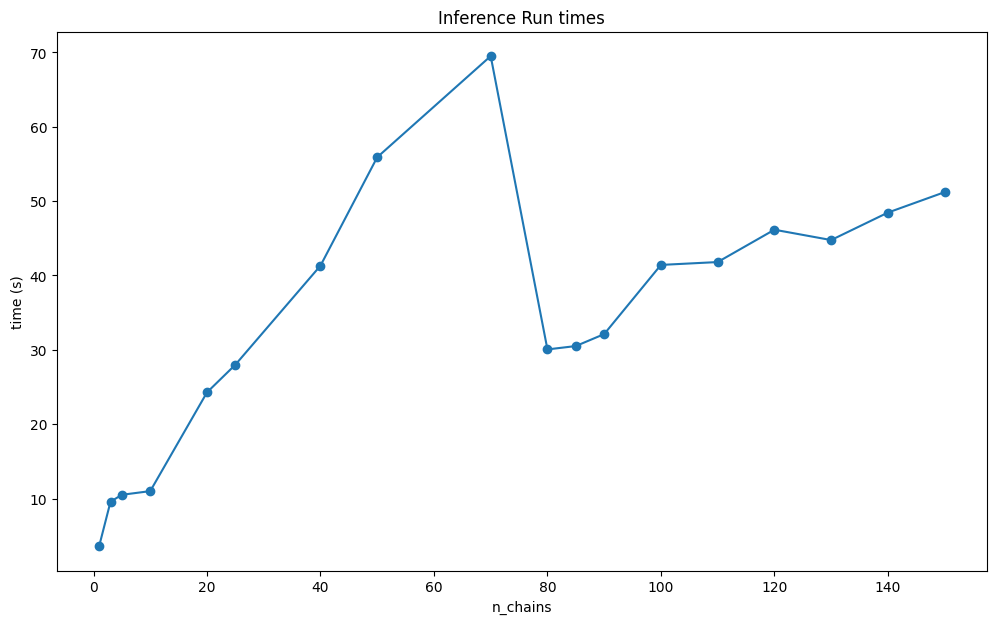

In [25]:

plt.figure(figsize=(12,7))

plt.title("Inference Run times")

rt = [d[n]['inference_run_time'] for n in N_CHAINS]

plt.plot(N_CHAINS, rt, '-o', color='C0')


plt.ylabel("time (s)")
plt.xlabel("n_chains")


In [31]:
d[1]['inference_run_time'], d[1]['warmup_run_time']

(3.607454776763916, 2.735405445098877)

In [27]:
tt = d[80]['warmup_run_time'] + d[80]['inference_run_time']
tt2 = d[1]['warmup_run_time'] + d[1]['inference_run_time']

tt2 * 80 / tt

6.55553842164991

In [29]:
tt = d[80]['warmup_run_time'] + d[80]['inference_run_time']
tt2 = d[5]['warmup_run_time'] + d[5]['inference_run_time']

tt2 * 16 / tt

4.915514452580832

In [100]:
sample_sec

array([ 277.2037522 ,  313.2222639 ,  476.016921  ,  909.22497527,
        823.98164434,  893.03075993,  968.26287318,  894.59864322,
       1007.28389678, 2662.18577236, 2786.58041871, 2802.75877619,
       2414.68660932, 2631.73527363, 2600.40248655, 2904.62611845,
       2889.6422485 , 2929.79137434])

Text(0, 0.5, 'samples / sec')

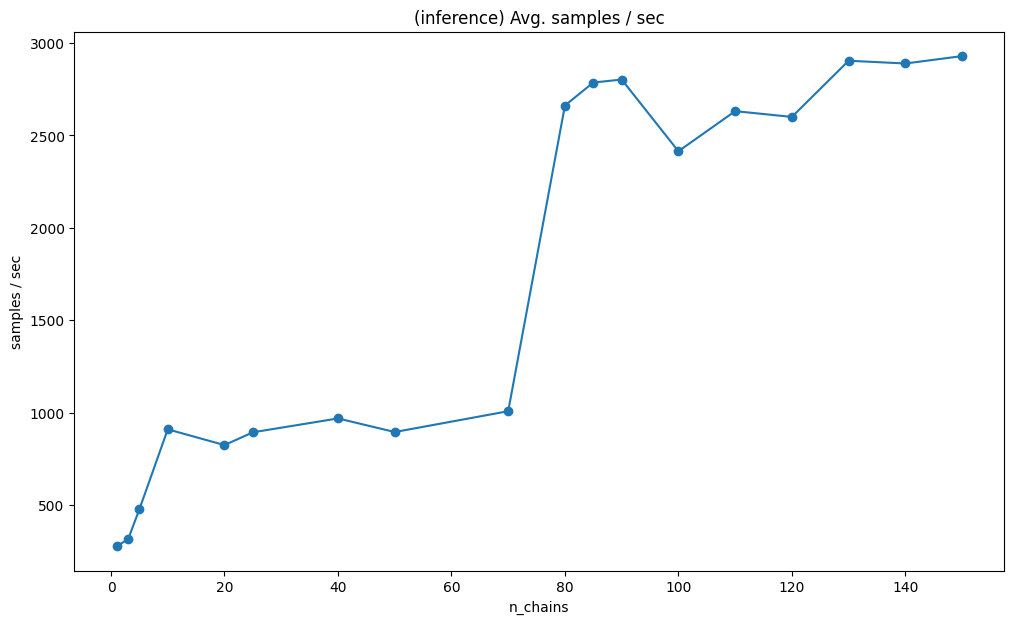

In [79]:
# every chain produces 1000 samples, so let's instead compare avg. time per sample. 
plt.figure(figsize=(12,7))

plt.title("(inference) Avg. samples / sec")

tt = np.array([ d[n]['inference_run_time'] for n in N_CHAINS])
sample_sec = (np.array(N_CHAINS)*1000) / tt # avg. time to get 1 sample

plt.plot(N_CHAINS, sample_sec, '-o', color='C0')


plt.xlabel("n_chains")
plt.ylabel("samples / sec")

In [103]:
sample_sec

array([ 157.65758113,  139.90899303,  210.25883262,  383.67741965,
        344.62416457,  369.44436076,  381.66461046,  374.70158129,
        393.45050933, 1033.53033054, 1067.1559222 , 1068.23089053,
       1028.79626779, 1097.75474651, 1050.25276355, 1135.80591148,
       1126.74942004, 1140.88484031])

Text(0, 0.5, 'samples / sec')

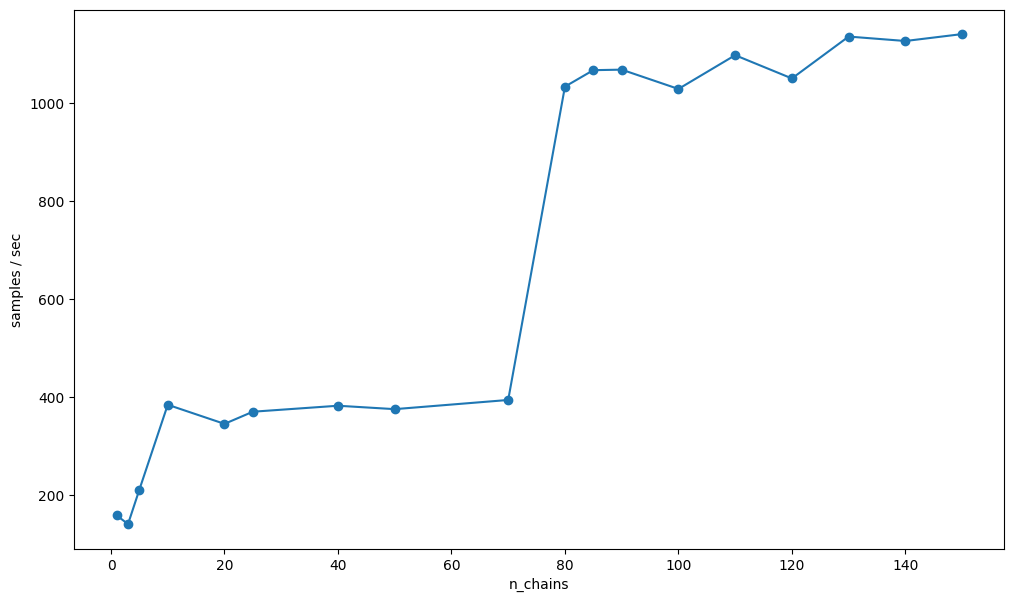

In [101]:
# every chain produces 1000 samples, so let's instead compare avg. time per sample. 
plt.figure(figsize=(12,7))

tt = np.array([ d[n]['inference_run_time'] + d[n]['warmup_run_time'] for n in N_CHAINS])
sample_sec = (np.array(N_CHAINS)*1000) / tt # avg. time to get 1 sample

plt.plot(N_CHAINS, sample_sec, '-o', color='C0')


plt.xlabel("n_chains")
plt.ylabel("samples / sec")

In [84]:
N_CHAINS

array([  1,   3,   5,  10,  20,  25,  40,  50,  70,  80,  85,  90, 100,
       110, 120, 130, 140, 150])

Text(0, 0.5, 'avg. samples / sec')

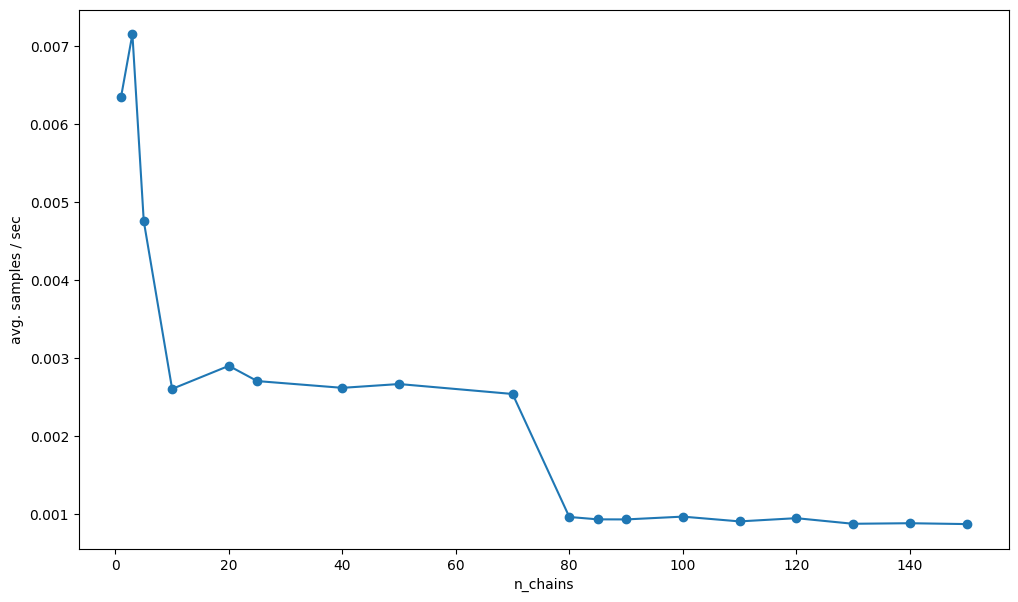

In [93]:
# every chain produces 1000 samples, so let's instead compare avg. time per sample. 
plt.figure(figsize=(12,7))

# plt.title("Avg. time to get 1 sample")

wt =np.array([ d[n]['warmup_run_time']for n in N_CHAINS])
rt = np.array([ d[n]['inference_run_time'] for n in N_CHAINS])
avg_samples_per_time = (wt + rt) / (N_CHAINS * 1000)

plt.plot(N_CHAINS, avg_samples_per_time, '-o', color='C0')


plt.xlabel("n_chains")
plt.ylabel("avg. samples / sec")

In [95]:
# # every chain produces 1000 samples, so let's instead compare avg. time per sample. 
# plt.figure(figsize=(12,7))

# plt.title("Avg. time to get 1 sample")

# wt =np.array([ d[n]['warmup_run_time']for n in N_CHAINS])
# rt = np.array([ d[n]['inference_run_time'] for n in N_CHAINS])
# time_to_get_one_sample = wt / N_CHAINS + (rt / (N_CHAINS *1000))

# plt.plot(N_CHAINS, time_to_get_one_sample, '-o', color='C0')


# plt.xlabel("n_chains")
# plt.ylabel("avg. time 1 sample (sec)")

In [98]:
# # every chain produces 1000 samples, so let's instead compare avg. time per sample. 
# plt.figure(figsize=(12,7))

# plt.title("Avg. time per sample")

# tt = np.array([ d[n]['warmup_run_time'] + d[n]['inference_run_time'] for n in N_CHAINS])
# avg_time_per_sample = tt / (np.array(N_CHAINS)*1000) # avg. time to get 1 sample

# plt.plot(N_CHAINS, avg_time_per_sample*1000, '-o', color='C0')


# plt.xlabel("n_chains")
# plt.ylabel("avg. time per sample (ms)")

In [97]:
# # now calculate avg time per effective sample
# plt.figure(figsize=(12,7))

# plt.title("Avg. time per effecrtive sample")
# # just for g1 to simplify

# _N_CHAINS1 = N_CHAINS[1:]

# ess = np.array([ jnp.clip(effective_sample_size(d[n]['states'].position['g1'], chain_axis=0, sample_axis=1), max=(n*1000)) for n in _N_CHAINS1])
# tt = np.array([ d[n]['warmup_run_time'] + d[n]['inference_run_time'] for n in _N_CHAINS1])
# avg_time_per_eff_sample = tt / ess # avg. time to get 1 sample

# plt.plot(_N_CHAINS1, avg_time_per_eff_sample*1000, '-o', color='C0')


# plt.xlabel("n_chains")
# plt.ylabel("avg. time per sample (ms)")

Text(0, 0.5, 'eff # samples / sec')

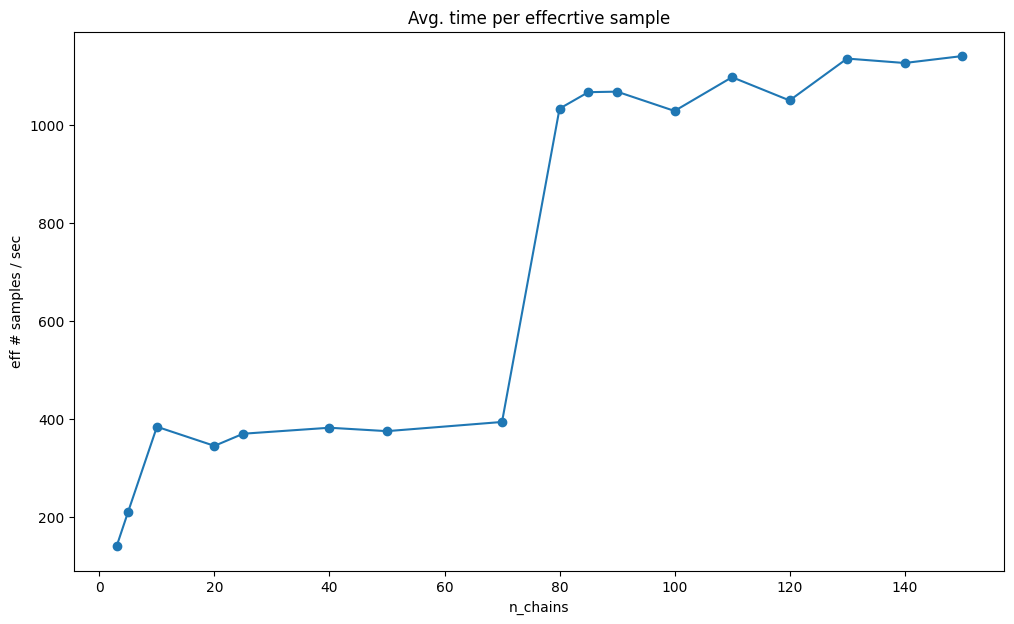

In [99]:
# now calculate avg time per effective sample
plt.figure(figsize=(12,7))

plt.title("Avg. time per effecrtive sample")
# just for g1 to simplify

_N_CHAINS1 = N_CHAINS[1:]

ess = np.array([ jnp.clip(effective_sample_size(d[n]['states'].position['g1'], chain_axis=0, sample_axis=1), max=(n*1000)) for n in _N_CHAINS1])
tt = np.array([ d[n]['warmup_run_time'] + d[n]['inference_run_time'] for n in _N_CHAINS1])
eff_sample_per_sec = ess / tt # avg. time to get 1 sample

plt.plot(_N_CHAINS1, eff_sample_per_sec, '-o', color='C0')


plt.xlabel("n_chains")
plt.ylabel("eff # samples / sec")

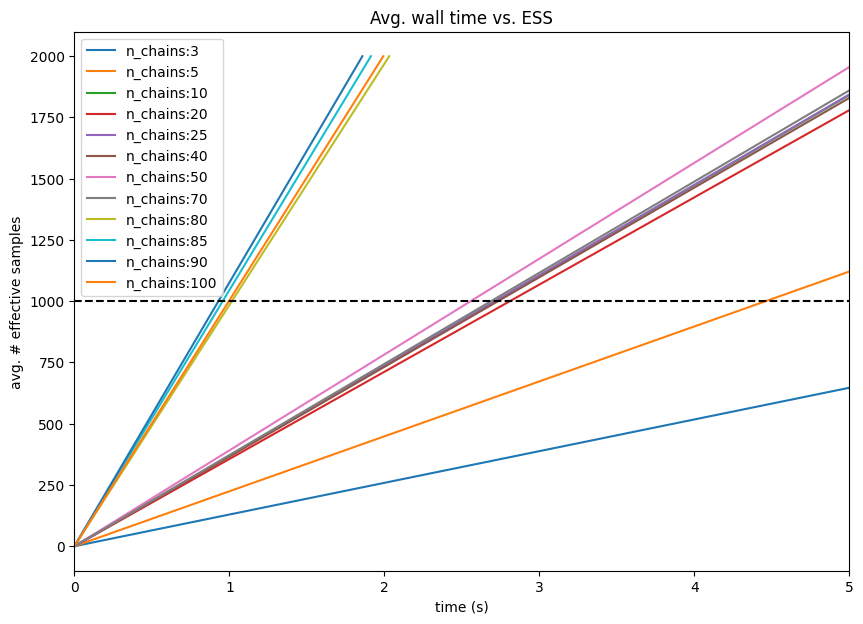

In [160]:
## now for the money plot
# as a function of time how many effective samples can we get? 
plt.figure(figsize=(10,7))
plt.title("Avg. wall time vs. ESS")

_N_CHAINS1 = N_CHAINS[1:]

ess = np.array([ jnp.clip(effective_sample_size(d[n]['states'].position['g1'], chain_axis=0, sample_axis=1), max=(n*1000)) for n in _N_CHAINS1])
tt = np.array([ d[n]['warmup_run_time'] + d[n]['inference_run_time'] for n in _N_CHAINS1])
avg_time_per_eff_sample = tt / ess # avg. time to get 1 effective sample

for ii, n in enumerate(_N_CHAINS1):
    mean_t = avg_time_per_eff_sample[ii]
    x = mean_t * np.arange(0, 2000)
    y = np.arange(0, 2000)
    plt.plot(x, y, '-', label=f'n_chains:{n}')

plt.xlim(0, 5)
plt.xlabel("time (s)")
plt.ylabel("avg. # effective samples")
plt.legend()
plt.axhline(1000, color='k', linestyle='--')


Text(0, 0.5, 'r-hat')

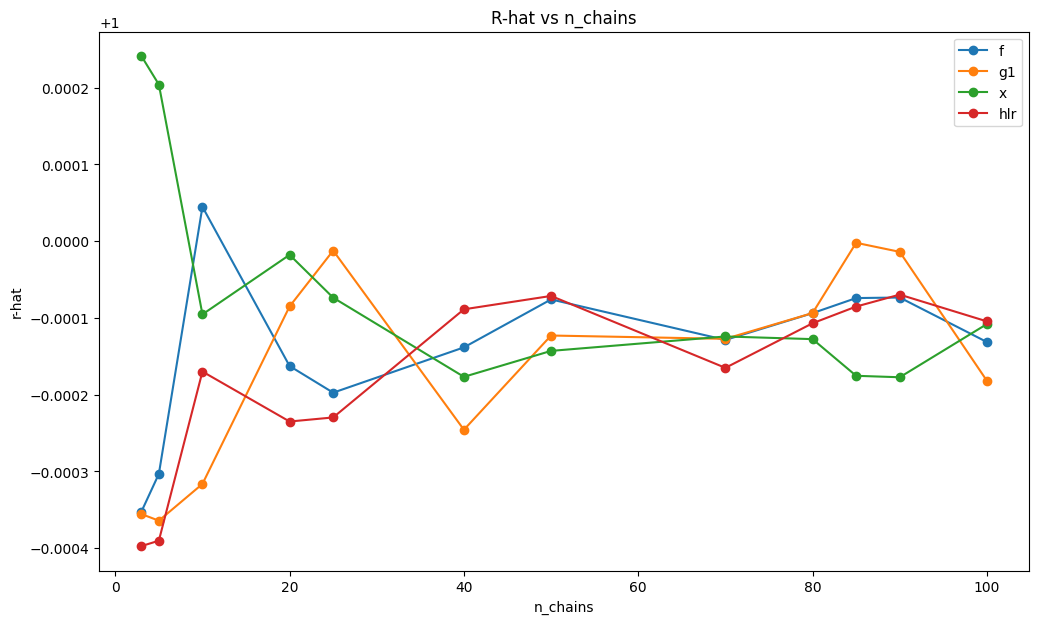

In [39]:
# we need to check r-hats

# Q: do we need to look as a function of samples? 

plt.figure(figsize=(12,7))

plt.title("R-hat vs n_chains")


_N_CHAINS1 = N_CHAINS[1:]

for p in {'f', 'hlr', 'g1', 'x'}:
    r_hat = [potential_scale_reduction(d[n]['states'].position[p], chain_axis=0, sample_axis=1) for n in _N_CHAINS1]

    plt.plot(_N_CHAINS1, r_hat, '-o', label=p)

plt.legend()

plt.xlabel("n_chains")
plt.ylabel("r-hat")

Text(0, 0.5, '# divergences')

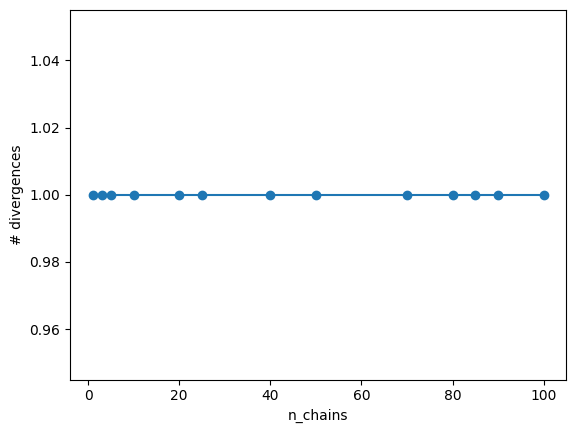

In [164]:
# of divergences for n_chains


colors = ['C0', 'C1', 'C2', 'C3']

divs = [d[n]['info'].is_divergent.sum() for n_chain in N_CHAINS]

plt.plot(N_CHAINS, divs, '-o')

plt.xlabel("n_chains")
plt.ylabel("# divergences")


# Efficiency money plot

In [62]:
d[1]['warmup_run_time'], d[1]['inference_run_time']

(2.735405445098877, 3.607454776763916)

In [40]:
d[100]['warmup_run_time'], d[100]['inference_run_time']

(55.78773307800293, 41.41324162483215)

In [38]:
N_CHAINS

array([  1,   3,   5,  10,  20,  25,  40,  50,  70,  80,  85,  90, 100,
       110, 120, 130, 140, 150])

In [41]:
N_CHAINS

array([  1,   3,   5,  10,  20,  25,  40,  50,  70,  80,  85,  90, 100,
       110, 120, 130, 140, 150])

In [51]:
times[1][110:120], times[100][110:120]

(array([3.13583293, 3.13944038, 3.14304783, 3.14665529, 3.15026274,
        3.1538702 , 3.15747765, 3.16108511, 3.16469256, 3.16830002]),
 array([0.60384603, 0.60426016, 0.60467429, 0.60508843, 0.60550256,
        0.60591669, 0.60633082, 0.60674496, 0.60715909, 0.60757322]))

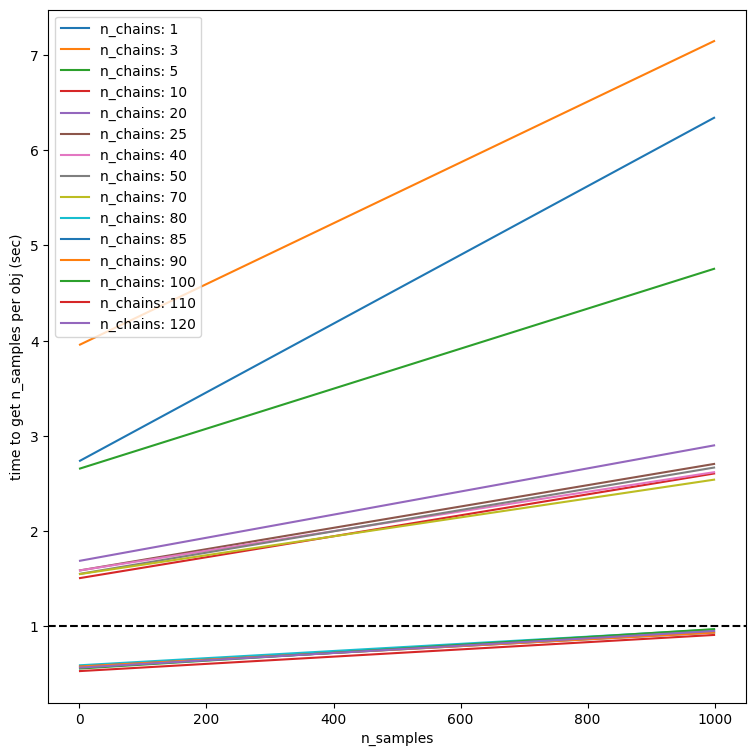

In [53]:
# assuming these results hold for arbitrary number of objects
# let's do just # samples later do effective samples

# we will compute the relative efficiency per objt as a function of samples. 
# i.e. time to get n_samlpes / per_obj w/ N_chains / (time to get n_samples per_obj w/ 1 chain)

plt.figure(figsize=(9, 9))

n_samples = np.arange(1, 1000)
_N_CHAINS = N_CHAINS[:15]
_N_CHAINS1 = _N_CHAINS[1:]

times = {n:[] for n in _N_CHAINS}
for n in _N_CHAINS:
    # warmup is fixed regardless of how many samples we want
    # inference is for 1000 samples per obj always so divide by 1000
    t = (  d[n]['warmup_run_time'] + (d[n]['inference_run_time'] / 1000 * n_samples) ) / n # for simplicity, assume each chain runs on different object, later need to test actualy different galaxies.
    times[n] = t
    
for n in _N_CHAINS:
    plt.plot(n_samples, times[n], label=f'n_chains: {n}')
    
plt.legend()

plt.ylabel("time to get n_samples per obj (sec)")
plt.xlabel("n_samples")

plt.axhline(1.0, color='k', linestyle='--')

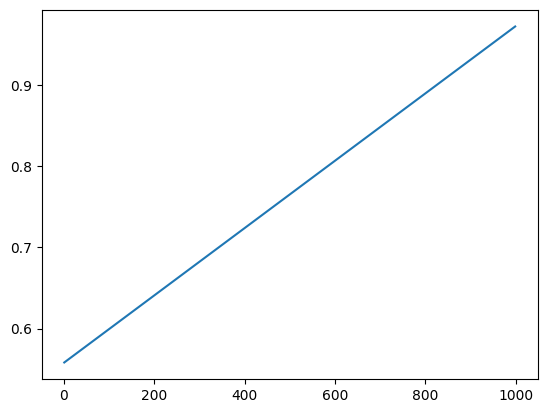

In [55]:
plt.plot(n_samples ,times[100])

In [43]:
## metrics: check posterior with (1000, 2000, 10000) samples 
# (1) 1 chain with 1000 
# (2) 10 chains with 100
# (3) 100 chains with 10 
# See how posterior change, how long it does it take to run, plot posterior how they look like. 
# different levels of SNR = (10e3, 50, 15, 10), same object, same noise realization, different initilization
# visual inspection of posterior, looking at 1d histogram of chains
# sample initialization from prior

In [ ]:
# include time to transfer obj to GPU
# check different transfer times for different size of batches of objects

# in avg. processing 1 obj will take this amount of time (~1000 samples) -- check euclid/JIF
# Michael's approach depends on how many galaxies per sample e.g. cell coadds ~100 galaxies in region where shear is constant

In [60]:
d[100]['warmup_run_time'],  d[100]['inference_run_time']/ 100

(55.78773307800293, 0.41413241624832153)

In [44]:
times.keys(), d.keys()

(dict_keys([1, 3, 5, 10, 20, 25, 40, 50, 70, 80, 85, 90, 100, 110, 120]),
 dict_keys([1, 3, 5, 10, 20, 25, 40, 50, 70, 80, 85, 90, 100, 110, 120, 130, 140, 150]))

In [56]:
times[100][99]

0.5992905724048615

In [51]:
n_samples = 10
rate = (d[100]['warmup_run_time'] + (d[100]['inference_run_time'] / 1000) * n_samples)  / 100
rate

0.5620186549425125

In [57]:
6, (d[100]['warmup_run_time'] + d[100]['inference_run_time'] / 100), times[100][9]* 100

(6, 56.20186549425125, 56.201865494251244)

In [ ]:
%% time 

In [2]:
from bpd.
get_snr??

Object `get_snr` not found.


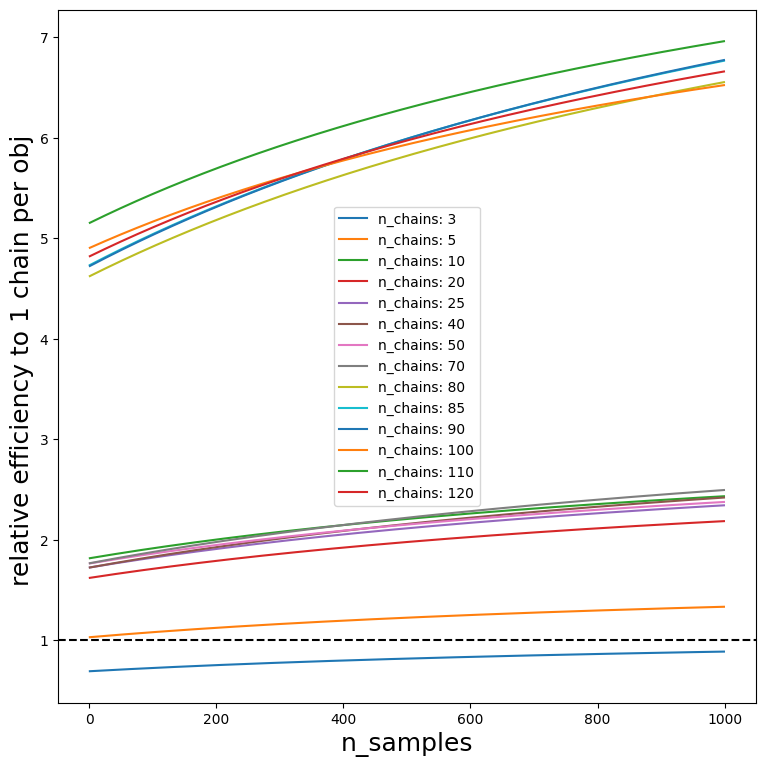

In [64]:
# assuming these results hold for arbitrary number of objects
# let's do just # samples later do effective samples

# we will compute the relative efficiency per objt as a function of samples. 
# i.e. time to get n_samlpes / per_obj w/ N_chains / (time to get n_samples per_obj w/ 1 chain)

plt.figure(figsize=(9, 9))

n_samples = np.arange(1, 1000)
_N_CHAINS = N_CHAINS[:15]
_N_CHAINS1 = _N_CHAINS[1:]

times = {n:[] for n in _N_CHAINS}
for n in _N_CHAINS:
    # warmup is fixed regardless of how many samples we want
    # inference is for 1000 samples per obj always so divide by 1000
    t = (d[n]['warmup_run_time'] + (d[n]['inference_run_time'] / 1000 * n_samples) ) / n # for simplicity, assume each chain runs on different object, later need to test actualy different galaxies.
    times[n] = t
    
for n in _N_CHAINS1:
    plt.plot(n_samples, times[1] / times[n], label=f'n_chains: {n}')
    
plt.legend()

plt.ylabel("relative efficiency to 1 chain per obj ", fontsize=18)
plt.xlabel("n_samples", fontsize=18)

plt.axhline(1.0, color='k', linestyle='--')

In [66]:
d.keys()

dict_keys([1, 3, 5, 10, 20, 25, 40, 50, 70, 80, 85, 90, 100, 110, 120, 130, 140, 150])

Text(0.5, 0, 'n_chains')

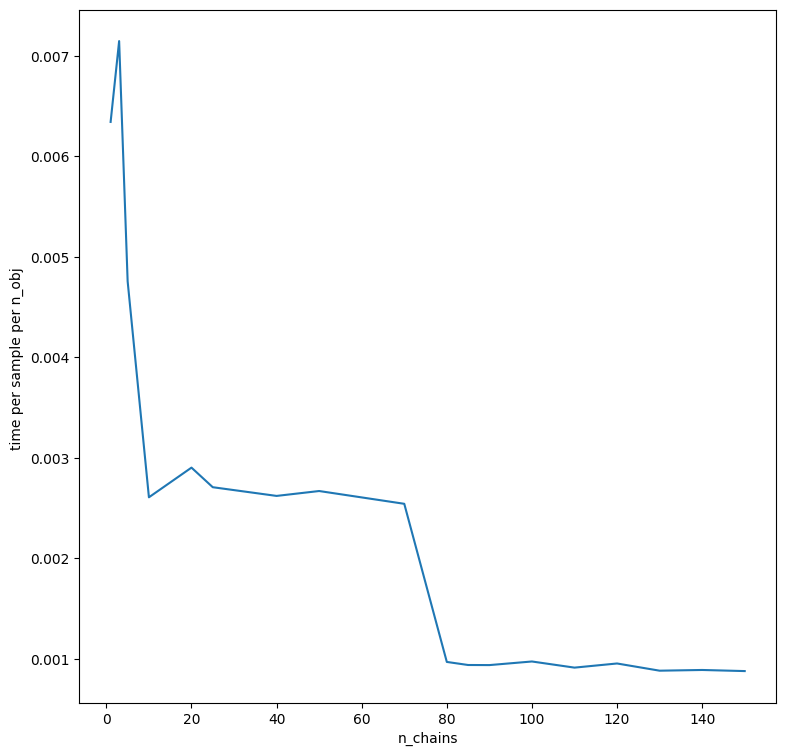

In [65]:
# time per sample per object
plt.figure(figsize=(9, 9))


times = []
for n in N_CHAINS: 
    total_time = d[n]['warmup_run_time']  + d[n]['inference_run_time']
    time_to_get_1_sample_for_every_object = total_time / 1000
    time_to_get_1_sample_1_object = time_to_get_1_sample_for_every_object / n

                                             
    times.append(time_to_get_1_sample_1_object)

    
plt.plot(N_CHAINS, times)
# plt.legend()

plt.ylabel("time per sample per n_obj ")
plt.xlabel("n_chains")

# plt.axhline(1.0, color='k', linestyle='--')